### Importing packages

In [59]:
import pandas as pd
pd.set_option("display.max_colwidth",200)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import seaborn as sns
color = sns.color_palette()
from tqdm import tqdm
from urllib.parse import urlparse
import warnings
warnings.filterwarnings(action="ignore")
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_predict, GroupKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack

In [3]:
df = pd.read_csv("webpage data.csv")
df.head()

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,http://www.fiercepharma.com/marketing/tecfidera-gilenya-and-aubagio-s-3-way-battle-for-ms-share-about-to-get-more-interesting,news
1,2,www.fiercepharma.com,http://www.fiercepharma.com/pharma/novo-equipped-to-weather-storm-u-s-diabetes-market-ceo-says,news
2,3,www.fiercepharma.com,http://www.fiercepharma.com/pharma/another-exec-departs-troubled-endo-and-time-it-s-for-another-drugmaker,news
3,4,www.fiercepharma.com,http://www.fiercepharma.com/pharma/teva-buy-biosim-specialist-celltrion-it-wouldn-t-say-no,news
4,5,www.fiercepharma.com,http://www.fiercepharma.com/marketing/actress-marissa-tomei-partners-allergan-restasis-to-drive-dry-eye-awareness,news


In [5]:
df.shape

(53229, 4)

In [4]:
df['Tag'].unique()

array(['news', 'clinicalTrials', 'conferences', 'profile', 'forum',
       'publication', 'thesis', 'guidelines', 'others'], dtype=object)

In [7]:
df[df['Tag']=='news'].head(2)

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,http://www.fiercepharma.com/marketing/tecfidera-gilenya-and-aubagio-s-3-way-battle-for-ms-share-about-to-get-more-interesting,news
1,2,www.fiercepharma.com,http://www.fiercepharma.com/pharma/novo-equipped-to-weather-storm-u-s-diabetes-market-ceo-says,news


In [8]:
df[df['Tag']=='clinicalTrials'].head(2)

,Webpage_id,Domain,Url,Tag
30,36,upload.umin.ac.jp,https://upload.umin.ac.jp/cgi-open-bin/ctr_e/ctr_view.cgi?recptno=R000018186,clinicalTrials
31,39,upload.umin.ac.jp,https://upload.umin.ac.jp/cgi-open-bin/ctr_e/ctr_view.cgi?recptno=R000018428,clinicalTrials


In [9]:
df[df['Tag']=='conferences'].head(2)

,Webpage_id,Domain,Url,Tag
550,1028,investors.alphatecspine.com,http://investors.alphatecspine.com/events.cfm,conferences
1033,1773,ir.alk.net,http://ir.alk.net/events.cfm,conferences


In [12]:
df[df['Tag']=='profile'].head(2)

,Webpage_id,Domain,Url,Tag
3476,5096,www.healthcare4ppl.com,http://www.healthcare4ppl.com/physician/wisconsin/waukesha/andrew-v-beykovsky-1114036092.html,profile
3477,5097,www.healthcare4ppl.com,http://www.healthcare4ppl.com/physician/west-virginia/morgantown/clare-m-mcdaniel-1346231032.html,profile


In [13]:
df[df['Tag']=='forum'].head(2)

,Webpage_id,Domain,Url,Tag
3689,5549,community.beatingbowelcancer.org,http://community.beatingbowelcancer.org/forum/926-post-op,forum
3765,5714,rollitup.org,http://rollitup.org/t/someguys-led-other-grows-2014-15-season.851562/page-82,forum


In [10]:
df[df['Tag']=='publication'].head(2)

,Webpage_id,Domain,Url,Tag
4164,6295,jvi.asm.org,http://jvi.asm.org/content/87/9/4994.long,publication
4165,6296,iai.asm.org,http://iai.asm.org/content/77/7/3033.long,publication


In [14]:
df[df['Tag']=='thesis'].head(2)

,Webpage_id,Domain,Url,Tag
5118,7526,ecommons.cornell.edu,https://ecommons.cornell.edu/handle/1813/29484,thesis
5119,7527,ecommons.cornell.edu,https://ecommons.cornell.edu/handle/1813/11185,thesis


In [11]:
df[df['Tag']=='guidelines'].head(2)

,Webpage_id,Domain,Url,Tag
6954,10201,www.nice.org.uk,https://www.nice.org.uk/guidance/indevelopment/gid-ta10173,guidelines
6955,10203,www.nice.org.uk,https://www.nice.org.uk/guidance/indevelopment/gid-ng10073,guidelines


In [15]:
df[df['Tag']=='others'].head(2)

,Webpage_id,Domain,Url,Tag
6970,10229,joannabriggs.org,http://joannabriggs.org/,others
7152,10679,www.copdx.org.au,http://copdx.org.au/,others


* Looking at the samples, we can see that there are a few words in the URLs that are appearing consistently for each category. For example: there is the word forum for URLs of tag forum, gid for the URLs of tag guidelines and cfm for conferences. 
* This implies that it would be a good idea to actually find out the frequency of each word and use that as a feature

### Target Exploration

Text(0, 0.5, 'Frequency of tags')

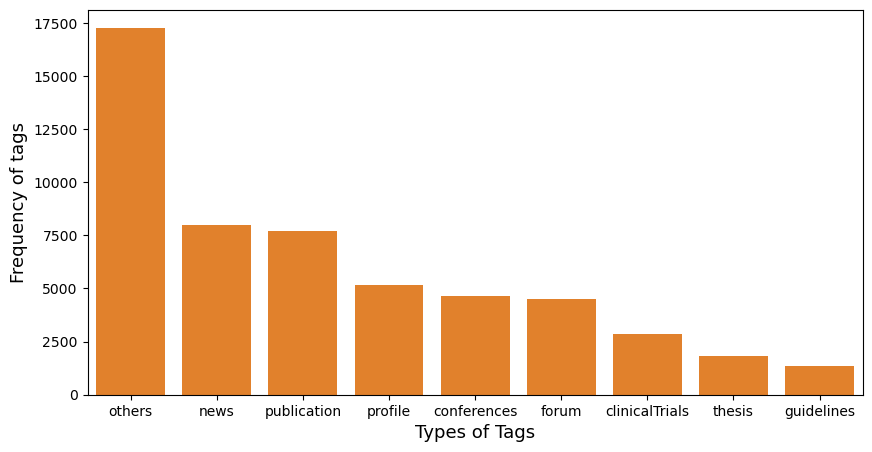

In [25]:
plt.figure(figsize=(10,5))
sns.barplot(x=df['Tag'].value_counts().index,y=df['Tag'].value_counts().values,color=color[1])
plt.xlabel("Types of Tags", fontsize=13)
plt.ylabel('Frequency of tags',fontsize=13)

### Understanding the common words used in URL

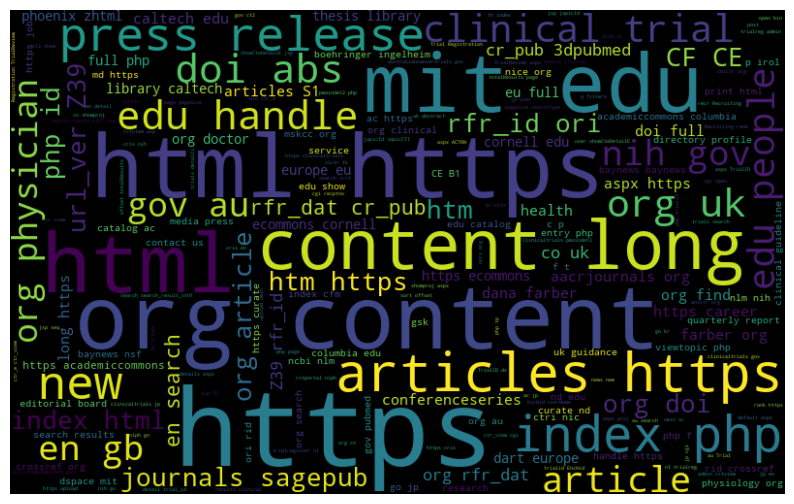

In [29]:
all_words = " ".join([text for text in df['Url']])
from wordcloud import WordCloud
wordcolud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcolud, interpolation='bilinear')
plt.axis('off')
plt.show()

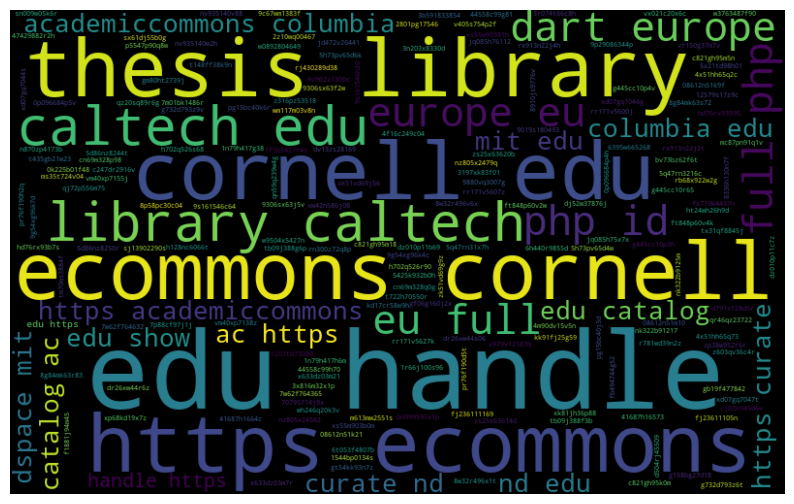

In [32]:
# word_cloud for thesis

all_words = " ".join([text for text in df['Url'][df['Tag']=='thesis']])
from wordcloud import WordCloud
wordcolud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcolud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Feature Extraction

In [34]:
def clean_url(df):
    df['Url'] = df['Url'].str.replace('/',' ')
    df['Url'] = df['Url'].str.replace('-', ' ')
    df['Url'] = df['Url'].str.replace('https:','')
    df['Url'] = df['Url'].str.replace('http:','')
    return df

In [35]:
df= clean_url(df)

In [36]:
df.head()

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,www.fiercepharma.com marketing tecfidera gilenya and aubagio s 3 way battle for ms share about to get more interesting,news
1,2,www.fiercepharma.com,www.fiercepharma.com pharma novo equipped to weather storm u s diabetes market ceo says,news
2,3,www.fiercepharma.com,www.fiercepharma.com pharma another exec departs troubled endo and time it s for another drugmaker,news
3,4,www.fiercepharma.com,www.fiercepharma.com pharma teva buy biosim specialist celltrion it wouldn t say no,news
4,5,www.fiercepharma.com,www.fiercepharma.com marketing actress marissa tomei partners allergan restasis to drive dry eye awareness,news


### Bag-of-words features

In [38]:
vec_bow = CountVectorizer(ngram_range=(1,3),min_df=300)
vec_bow.fit(df['Url'])
Url_bow = vec_bow.transform(df['Url'])

### Model Validation

In [42]:
df['target_str'] = df['Domain'].astype(str)+"_"+df['Tag'].astype(str)
cv_list = list(GroupKFold(5).split(df,groups=df['target_str']))

In [43]:
df.head()

,Webpage_id,Domain,Url,Tag,target_str
0,1,www.fiercepharma.com,www.fiercepharma.com marketing tecfidera gilenya and aubagio s 3 way battle for ms share about to get more interesting,news,www.fiercepharma.com_news
1,2,www.fiercepharma.com,www.fiercepharma.com pharma novo equipped to weather storm u s diabetes market ceo says,news,www.fiercepharma.com_news
2,3,www.fiercepharma.com,www.fiercepharma.com pharma another exec departs troubled endo and time it s for another drugmaker,news,www.fiercepharma.com_news
3,4,www.fiercepharma.com,www.fiercepharma.com pharma teva buy biosim specialist celltrion it wouldn t say no,news,www.fiercepharma.com_news
4,5,www.fiercepharma.com,www.fiercepharma.com marketing actress marissa tomei partners allergan restasis to drive dry eye awareness,news,www.fiercepharma.com_news


In [44]:
cv_list

[(array([    0,     1,     2, ..., 53226, 53227, 53228]),
  array([   35,    36,    37, ..., 53095, 53096, 53097])),
 (array([    0,     1,     2, ..., 53226, 53227, 53228]),
  array([   92,    93,    94, ..., 52815, 52816, 52817])),
 (array([    0,     1,     2, ..., 53226, 53227, 53228]),
  array([   34,    39,    55, ..., 53213, 53215, 53216])),
 (array([    0,     1,     2, ..., 53213, 53215, 53216]),
  array([   38,    58,   146, ..., 53226, 53227, 53228])),
 (array([   34,    35,    36, ..., 53226, 53227, 53228]),
  array([    0,     1,     2, ..., 53025, 53026, 53027]))]

### Converting tags from strings to numbers

In [48]:
x = Url_bow

TAG_DICT = {"others":1, "news": 2, "publication":3, "profile": 4,
            "conferences": 5, "forum": 6, "clinicalTrials": 7,
            "thesis": 8, "guidelines": 9}

df['target'] = df.Tag.map(TAG_DICT)
y = df["target"].values

In [53]:
def cv_score(ml_model, df):
    i = 1
    cv_scores = []
    X = df
    
    # Custom Cross validation based on group KFold
    for df_index,test_index in cv_list:
        print('\n{} of Group kfold {}'.format(i,5))
        xtr,xvl = X[df_index],X[test_index]
        ytr,yvl = y[df_index],y[test_index]
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        label_preds = np.argmax(pred_probs, axis=1) + 1
        
        # Calculate scores for each fold and print
        score = f1_score(yvl, label_preds, average="weighted")
        sufix = ""
        msg = ""
        msg += "Weighted F1 Score: {}".format(score)
        print("{}".format(msg))
         
         # Save scores
        cv_scores.append(score)
        i+=1
    return cv_scores

### Naive Bayes

In [54]:
cv_score(MultinomialNB(alpha=.01), Url_bow)


1 of Group kfold 5
Weighted F1 Score: 0.6142666078237405

2 of Group kfold 5
Weighted F1 Score: 0.6011652483250214

3 of Group kfold 5
Weighted F1 Score: 0.5844037341828198

4 of Group kfold 5
Weighted F1 Score: 0.6780442272119549

5 of Group kfold 5
Weighted F1 Score: 0.6781849423781955


[0.6142666078237405,
 0.6011652483250214,
 0.5844037341828198,
 0.6780442272119549,
 0.6781849423781955]

In [55]:
# Word and character BOW on URLs
vec1 = CountVectorizer(analyzer='char', ngram_range=(1, 5), min_df=500)
vec2 = CountVectorizer(analyzer='word', ngram_range=(1, 3), min_df=400)
vec_bow = FeatureUnion([("char", vec1), ("word", vec2)])
vec_bow.fit(df['Url'])
Url_bow = vec_bow.transform(df['Url'])

In [67]:
nb = cv_score(MultinomialNB(alpha=.01), Url_bow)


1 of Group kfold 5
Weighted F1 Score: 0.6762799783456942

2 of Group kfold 5
Weighted F1 Score: 0.6850809337506776

3 of Group kfold 5
Weighted F1 Score: 0.688822967439938

4 of Group kfold 5
Weighted F1 Score: 0.7216948488261381

5 of Group kfold 5
Weighted F1 Score: 0.704485742627938


### TFIDF Features

In [60]:
# Word and character TFIDF on URLs
vec1 = TfidfVectorizer(analyzer='char', ngram_range=(1, 5), min_df=500)
vec2 = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=400)
vec_tfidf = FeatureUnion([("char", vec1), ("word", vec2)])
vec_tfidf.fit(df['Url'])
Url_tfidf = vec_tfidf.transform(df['Url'])

In [68]:
nb = cv_score(MultinomialNB(alpha=.01), Url_tfidf)


1 of Group kfold 5
Weighted F1 Score: 0.709831531814438

2 of Group kfold 5
Weighted F1 Score: 0.7028857528401553

3 of Group kfold 5
Weighted F1 Score: 0.7140138082517805

4 of Group kfold 5
Weighted F1 Score: 0.7474394007453241

5 of Group kfold 5
Weighted F1 Score: 0.7294679427204096


### Logistic Regression

In [69]:
log_reg = cv_score(LogisticRegression(C=0.1,class_weight='balanced'),Url_tfidf)


1 of Group kfold 5
Weighted F1 Score: 0.7001477047644526

2 of Group kfold 5
Weighted F1 Score: 0.7420657506101059

3 of Group kfold 5
Weighted F1 Score: 0.7467646471394166

4 of Group kfold 5
Weighted F1 Score: 0.7988550572649397

5 of Group kfold 5
Weighted F1 Score: 0.7921636915688668


### Decision Tree

In [70]:
dtree = cv_score(DecisionTreeClassifier(min_samples_leaf=25,min_samples_split=25),Url_tfidf)


1 of Group kfold 5
Weighted F1 Score: 0.6005452989385415

2 of Group kfold 5
Weighted F1 Score: 0.626694767801538

3 of Group kfold 5
Weighted F1 Score: 0.6239863924040036

4 of Group kfold 5
Weighted F1 Score: 0.6302743702596335

5 of Group kfold 5
Weighted F1 Score: 0.6515647118593498


### Random Forest

In [71]:
rf_params = {'random_state': 0, 'n_jobs': -1, 'n_estimators': 100, 'max_depth': 50, 'n_jobs': -1}
rf = cv_score(RandomForestClassifier(**rf_params), Url_tfidf)


1 of Group kfold 5
Weighted F1 Score: 0.6606028719369305

2 of Group kfold 5
Weighted F1 Score: 0.6788263035907093

3 of Group kfold 5
Weighted F1 Score: 0.6459859779651346

4 of Group kfold 5
Weighted F1 Score: 0.7276128735459069

5 of Group kfold 5
Weighted F1 Score: 0.7319454872882054


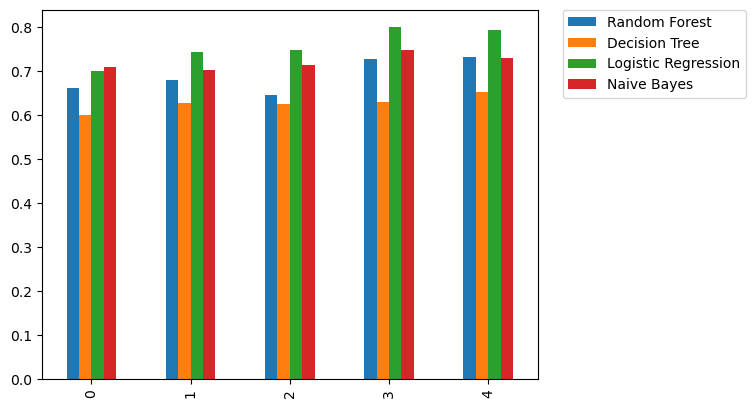

In [72]:
results_df = pd.DataFrame({'Random Forest':rf, 'Decision Tree': dtree, 'Logistic Regression': log_reg, 'Naive Bayes':nb})
results_df.plot(y=["Random Forest", "Decision Tree","Logistic Regression","Naive Bayes"], kind="bar")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()